# Creating boxplots to show variation in peptide expression between individual samples of each tissue type 

In [73]:
import Classification_Utils as cu
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
import pandas as pd
import seaborn as sns
from sklearn.externals import joblib

## Load Dataframe

In [74]:
df = pd.read_csv('FullPeptideQuant.txt', sep='\t', index_col='Peptide')
print(df.shape)

(55676, 253)


## Map each column to a corresponding label

In [75]:
tissues = ['Blood_Plasma', 'Blood_Serum', 'CSF', 'Liver', 'Monocyte', 'Ovary', 'Pancreas', 'Substantia_Nigra', 'Temporal_Lobe']
 
tissues_to_columns = cu.map_tissues_to_columns(df, tissues)
impute_val = df.mode().iloc[0, 0]

## Make filtered dataframes

### filtered_df: keep only peptides observed in at least 5 samples of each tissue

In [76]:
### Filter out peptides where less than [threshold] samples per tissue have non-imputed values

df_cols = df.columns.values.tolist()
organ_counts = {}
threshold = 5
    
for tissue in tissues:
    cols = [col for col in df_cols if col.startswith(tissue)] # Get corresponding list of column names
    organ_counts[tissue] = (df[cols] != impute_val).sum(1) # count number of samples with non-imputed abundance for each protein
    
conditions = list(organ_counts[t] >= threshold for t in tissues)
filtered_df = df[np.logical_and.reduce(conditions)]

In [77]:
filtered_df.shape

(9, 253)

### filtered_df2: keep only peptides observed in at least 5 samples of 4 to 6 different tissues

In [78]:
print(df.shape)

### Peptides observed in at least 5 samples of 4-6 tissues
filtered_df2 = cu.filter_peptides_by_samples_and_tissues(df, 5, 4, 6, tissues, impute_val)

print(filtered_df2.shape)

(55676, 253)
(2843, 253)


### single_tissue_observations_df: peptides only observed in a single tissue (in at least one sample)

In [79]:
print(df.shape)

### Peptides only observed in one of the tissues
single_tissue_observations_df = cu.filter_peptides_by_samples_and_tissues(df, 1, 1, 1, tissues, impute_val)

print(single_tissue_observations_df.shape)
print(single_tissue_observations_df.shape[0]/df.shape[0] *100)

(55676, 253)
(23359, 253)
41.95524103743085


In [80]:
column_names = df.columns.values.tolist()
labels = cu.get_labels(column_names, tissues_to_columns)

filtered_column_names = filtered_df.columns.values.tolist()
filtered_labels = cu.get_labels(filtered_column_names, tissues_to_columns)

filtered_column_names2 = filtered_df2.columns.values.tolist()
filtered_labels2 = cu.get_labels(filtered_column_names2, tissues_to_columns)

### filtered_df3: peptides observed in at least one sample of all 9 tissues

In [81]:
print(df.shape)

### Peptides observed in all tissues
filtered_df3 = cu.filter_peptides_by_samples_and_tissues(df, 1, 9, 9, tissues, impute_val)

print(filtered_df3.shape)
print(filtered_df3.shape[0]/df.shape[0] *100)

(55676, 253)
(48, 253)
0.08621309002083483


### filtered_df4: peptides observed in at least 5 samples of all 9 tissues

In [82]:
print(df.shape)

### Peptides observed in all tissues
filtered_df4 = cu.filter_peptides_by_samples_and_tissues(df, 5, 9, 9, tissues, impute_val)

print(filtered_df4.shape)
print(filtered_df4.shape[0]/df.shape[0] *100)

(55676, 253)
(9, 253)
0.01616495437890653


### Anova - how many peptides have significant difference in at least 1 tissue

In [83]:
import scipy.stats as stats
from statsmodels.sandbox.stats.multicomp import multipletests

def filter_peptides_by_anova(df, tissues, tissue_to_columns, pval=0.05):
    # Build list of peptides that pass ANOVA
    pass_anova = []
    ps=[]
    
    peptides = list(df.index)
    
    list_of_column_lists = [] # [['Liver_01', 'Liver_02'], ['CSF_01', 'CSF_02']]
    for tissue in tissues:
        cols = tissue_to_columns[tissue] # List of strings
        list_of_column_lists.append(cols) # List of lists of strings
        
    sub_frames = list(df[subset] for subset in list_of_column_lists) # List of dataframes
    
    # Perform ANOVA on each row (peptide) grouping by tissue, and adjust all p-values for multiple testing
    # If the peptide passes ANOVA, add it to the list of peptides to keep
    for i in range(df.shape[0]): 
        row_groups = [frame.iloc[i, :] for frame in sub_frames]
        f, p = stats.f_oneway(*row_groups)
        ps.append(p)

    adjusted_ps = multipletests(ps, method='bonferroni')[1]
    #adjusted_ps = multipletests(ps, method='fdr_bh')[1]
    
    for i in range(5):
        print('Original:', ps[i], 'Adjusted:', adjusted_ps[i])
        
    # Filter dataframe down to only include proteins in pass_anova
    for i in range(len(adjusted_ps)):
        if adjusted_ps[i] < pval:
            pass_anova.append(peptides[i])
        
    pass_anova_df = df[df.index.isin(pass_anova)]

    return pass_anova_df

In [84]:
pass_anova_df = filter_peptides_by_anova(df, tissues, tissues_to_columns)

print(df.shape)
print(pass_anova_df.shape)

print('Percent passing Anova:', pass_anova_df.shape[0]/df.shape[0] * 100)

Original: 5.9929877582e-23 Adjusted: 3.33665586425e-18
Original: 5.25203803953e-25 Adjusted: 2.92412469889e-20
Original: 2.20886779362e-18 Adjusted: 1.22980923277e-13
Original: 2.46824874841e-12 Adjusted: 1.37422217316e-07
Original: 2.31391445493e-15 Adjusted: 1.28829501193e-10
(55676, 253)
(48163, 253)
Percent passing Anova: 86.50585530569724


## Identify and isolate most and least highly variable peptides between tissues

In [85]:
liver_only_peptide_df = cu.keep_k_best_features(df, labels, 1)
high_variance_peptide_df = cu.keep_k_best_features(filtered_df, filtered_labels, 1)

all_but_least_variable_peptide = cu.keep_k_best_features(filtered_df,
                                                         filtered_labels, 
                                                         filtered_df.shape[0] - 2).index.values.tolist()

least_variable_peptides = list(set(filtered_df.index.values.tolist()) - set(all_but_least_variable_peptide))
least_variable_peptides_df = filtered_df.loc[least_variable_peptides, :]
low_variance_peptide_df = least_variable_peptides_df.drop(least_variable_peptides_df.index[1])

high_var_present_in_some_df = cu.keep_k_best_features(filtered_df2, filtered_labels, 1)

In [86]:
peptide_dfs = [liver_only_peptide_df,
               high_var_present_in_some_df,
               least_variable_peptides_df,
               high_variance_peptide_df]

In [87]:
peptides = liver_only_peptide_df.index.values.tolist() + high_var_present_in_some_df.index.values.tolist() + low_variance_peptide_df.index.values.tolist() + high_variance_peptide_df.index.values.tolist()

peptides = [p.strip('\n') for p in peptides]
peptides

['K.VLILGSGGLSIGQAGEFDYSGSQAVK.A',
 'R.LVAGEMGQNEPDQGGQR.G',
 'G.DQTVSDNELQEMSNQGSK.Y',
 'K.TYFPHFDLSHGSAQVK.G']

## For each peptide, gather abundances per sample/tissue

In [88]:
def get_summarized_df(df):

    data = {}
    
    for tissue in tissues:
        cols_to_drop = [col for col in df.columns if not col.startswith(tissue)]
        tissue_df = df.drop(cols_to_drop, axis=1).T
        tissue_df.rename(columns={tissue_df.columns[0]: tissue}, inplace=True)
        data[tissue] = tissue_df[tissue_df.columns[0]].tolist()

    combined_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in data.items() ]))
    return combined_df

In [89]:
summarized_dfs = [get_summarized_df(df) for df in peptide_dfs]

## Make Boxplots

In [90]:
color_dict = {} # Column name : color
num_colors = len(tissues)
colors = sns.color_palette('hls', num_colors)
color = 0

for col in summarized_dfs[0].columns.values:
    color_dict[col] = colors[color]
    color += 1

### Make individual boxplots for each peptide

In [91]:
image_dir = r'D:\images\Human_Tissues\\'

In [92]:
titles = ['Liver_Only', 'Low_Variance', 'High_Variance', '2nd_High_Variance']

for summarized_df, title in zip(summarized_dfs, titles):
    
    summarized_df = summarized_df.replace(impute_val, np.nan) ### Exclude imputed values
    
    fig, ax = plt.subplots(figsize = (10, 6))
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    sns.boxplot(data = summarized_df, palette = color_dict, ax = ax, linewidth=0.5)
    output_path = image_dir + title + '.pdf'

    plt.savefig(output_path, bbox_inches = "tight")
    plt.clf()

### Make combined boxplot showing all 4 peptides (Figure XX1)

In [93]:
### Group by tissue

stacked_dfs = []

for summarized_df, peptide in zip(summarized_dfs, peptides):
    # Remove underscores for cleaner legend before re-arranging dataframe
    summarized_df.columns = [col.replace('_', ' ') for col in summarized_df.columns.values]
    stacked_df = summarized_df.stack()
    
    stacked_df = stacked_df.reset_index().drop('level_0', axis=1)
    stacked_df.rename(columns={'level_1': 'Tissue', 0: 'Abundance'}, inplace=True)
    stacked_df = stacked_df.assign(Peptide=peptide)
    
    stacked_dfs.append(stacked_df)
    
combined_df = pd.concat([df for df in stacked_dfs])          # CONCATENATE
combined_df = combined_df.replace(impute_val, np.nan) # Exclude imputed values

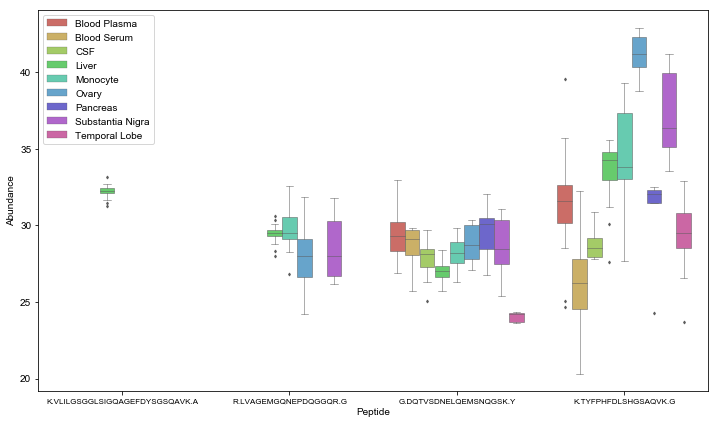

In [97]:
### Group by peptide

fig, ax = plt.subplots(figsize = (12, 7))
flierprops = dict(markersize=2) # define outlier properties

sns.boxplot(hue="Tissue", 
            x='Peptide', 
            y='Abundance', 
            data=combined_df, palette='hls', ax=ax, linewidth=0.5, flierprops=flierprops)

plt.rcParams["font.family"] = "Arial"
plt.legend(loc=0)
plt.xticks(fontsize=8),

output_path = image_dir + 'Grouped_By_Peptide' + '.pdf'    
plt.savefig(output_path, bbox_inches = "tight")  ### Figure XX1
plt.show()
plt.clf()